In [1]:
import jax.numpy as jnp
import jax.scipy as jsp
from jax import random
import jax

from typing import NamedTuple

from jaxgp.kernels import RBF
from jaxgp.utils import *

import matplotlib.pyplot as plt

In [2]:
def fun(x, noise=0.0, key = random.PRNGKey(0)):
    return (x[:,0]**2 + x[:,1] - 11)**2 / 800.0 + (x[:,0] + x[:,1]**2 -7)**2 / 800.0 + random.normal(key,(len(x),), dtype=jnp.float32)*noise

def grad(x, noise=0.0, key = random.PRNGKey(0)):
    dx1 = 4 * (x[:,0]**2 + x[:,1] - 11) * x[:,0] + 2 * (x[:,0] + x[:,1]**2 -7)
    dx2 = 2 * (x[:,0]**2 + x[:,1] - 11) + 4 * (x[:,0] + x[:,1]**2 -7) * x[:,1]

    return jnp.vstack((dx1, dx2)).T / 800.0 + random.normal(key,x.shape, dtype=jnp.float32)*noise

In [36]:
class Container(NamedTuple):
    u_inv: jnp.ndarray
    u_ref: jnp.ndarray
    diag: jnp.ndarray

def k_inv(X_split, X_ref, noise, kernel, params) -> Container:
    # Hardcoded squared noise between the reference points
    noise_ref = 1e-2

    # calculates the covariance between the training points and the reference points
    KF = CovMatrixFF(X_ref, X_split[0], kernel, params)
    KD = CovMatrixFD(X_ref, X_split[1], kernel, params)
    K_MN = jnp.hstack((KF,KD))

    # calculates the covariance between each pair of reference points
    K_ref = CovMatrixFF(X_ref, X_ref, kernel, params)
    diag_indices_ref = jnp.diag_indices(len(K_ref))
    K_ref = K_ref.at[diag_indices_ref].add(noise_ref**2)

    # upper cholesky factor of K_ref || U_ref.T@U_ref = K_ref
    U_ref = jsp.linalg.cholesky(K_ref)

    # V is solution to U_ref.T@V = K_MN
    V = jsp.linalg.solve_triangular(U_ref.T, K_MN, lower=True)

    # diag(K_NN)
    func = jax.vmap(lambda v: kernel.eval(v, v, params), in_axes=(0))(X_split[0])
    der = jnp.ravel(jax.vmap(lambda v: jnp.diag(kernel.jac(v, v, params)), in_axes=(0))(X_split[1]))
    K_NN_diag = jnp.hstack((func, der))
    # diag(Q_NN)
    Q_NN_diag = jax.vmap(lambda x: x.T@x, in_axes=(1,))(V)    
    # diag(K_NN) + noise**2 - diag(Q_NN)
    fitc_diag = K_NN_diag + noise**2 - Q_NN_diag
    
    def _mul_diag(diag, matrix):
        return diag*matrix
    mul_diag = jax.vmap(_mul_diag, in_axes=(0,0))

    # (1 / sqrt(fitc_diag))@V.T
    V_scaled = mul_diag(1 / jnp.sqrt(fitc_diag), V.T).T

    U_inv = jsp.linalg.cholesky((V_scaled@V_scaled.T).at[diag_indices_ref].add(1.0))

    return Container(U_inv, U_ref, fitc_diag)

In [37]:
# Interval bounds from which to choose the data points
bounds = jnp.array([-5.0, 5.0])

# How many function and derivative observations should be chosen
num_f_vals = 1
num_d_vals = 1000

# initial seed for the pseudo random key generation
seed = 0

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, (num_f_vals, 2), minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, (num_d_vals,2), minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.02
key, subkey = random.split(key)
y_func = fun(x_func,noise, subkey)
key, subkey = random.split(key)
y_der = grad(x_der, noise, subkey)

num_ref_points = (num_d_vals + num_f_vals) // 10
key, subkey = random.split(key)
X_ref_rand = random.permutation(subkey, jnp.vstack((x_der,x_func)))[:num_ref_points]
# this grid has fewer points. It has N points, where N is the largest perfect square smaller than num_ref_points
X_ref_even = jnp.array(jnp.meshgrid(jnp.linspace(*bounds, round(jnp.sqrt(num_ref_points))),jnp.linspace(*bounds, round(jnp.sqrt(num_ref_points))))).reshape(2,-1).T

X_split = [x_func,x_der]
Y_train = jnp.hstack((y_func, y_der.reshape(-1)))

kernel = RBF()
# an RBF kernel has per default 2 parameters

In [38]:
X_ref = X_ref_even

In [39]:
param_bounds = jnp.array([0.2,20.0])
num_params = 30
grid = jnp.linspace(*param_bounds, num_params)
params = jnp.array(jnp.meshgrid(grid,grid)).reshape(2,-1).T

In [40]:
def isnan(x):
    container = jax.jit(k_inv)(X_split, X_ref, noise, kernel, x)

    return jnp.any(jnp.isnan(container.u_inv)), jnp.any(jnp.isnan(container.u_ref))

In [41]:
res = []

for param in params:
    res.append(isnan(param))

res = jnp.array(res)
res = res.reshape(num_params, num_params, res.shape[-1])

Text(0.5, 1.0, 'isnan(U_ref).any()')

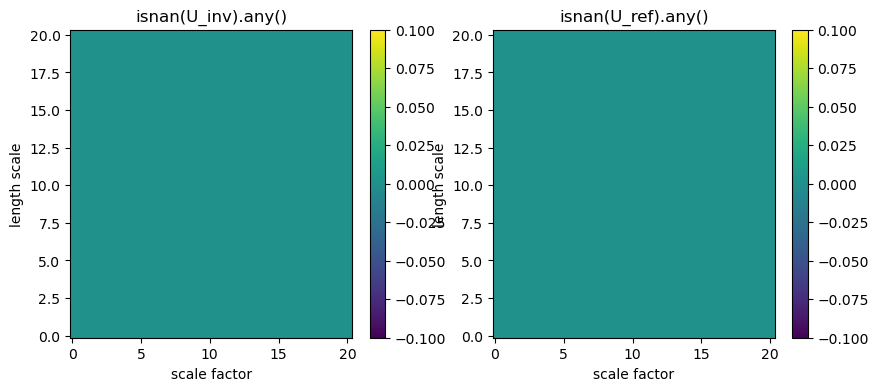

In [43]:
fig, ax = plt.subplots(1,len(res.T),figsize=(5*len(res.T),4))

for i,elem in enumerate(res.T):
    im = ax[i].pcolormesh(grid, grid, elem.T)
    plt.colorbar(im, ax=ax[i])
    ax[i].set_xlabel("scale factor")
    ax[i].set_ylabel("length scale")

ax[0].set_title("isnan(U_inv).any()")
ax[1].set_title("isnan(U_ref).any()")

In [7]:
def posdef(x):
    container = jax.jit(k_inv)(X_split, X_ref, noise, kernel, x)
    
    min_eigen = jnp.min(jnp.linalg.eigvals(container.k_inv))
    is_sym = jnp.allclose(container.k_inv, container.k_inv.T)

    return min_eigen, is_sym

def rel_err(x):
    container = jax.jit(k_inv)(X_split, X_ref, noise, kernel, x)
    
    err = jnp.max(jnp.abs(container.k_inv-container.k_inv.T))
    max_elem = jnp.max(container.k_inv)
    rel_err = err / max_elem

    return rel_err, err

def k_mn_contract(x):
    container = jax.jit(k_inv)(X_split, X_ref, noise, kernel, x)
    
    mat = jnp.diag(1 / container.diag)@container.k_mn.T

    return jnp.max(mat), jnp.min(mat), jnp.max(container.k_mn), jnp.min(container.k_mn)

def diag(x):
    container = jax.jit(k_inv)(X_split, X_ref, noise, kernel, x)

    return jnp.max(container.diag), jnp.min(container.diag)

def sqrt_diag_contract(x):
    container = jax.jit(k_inv)(X_split, X_ref, noise, kernel, x)

    return jnp.max(container.even_k_mn), jnp.min(container.even_k_mn)

def k_ref_mat_size(x):
    container = jax.jit(k_inv)(X_split, X_ref, noise, kernel, x)

    return jnp.max(container.k_ref), jnp.min(container.k_ref), jnp.max(container.even_k_mn.T@container.even_k_mn), jnp.min(container.even_k_mn.T@container.even_k_mn)

## Fixing `K_MN@(1 / diag)@K_MN.T`

In [9]:
res = []

for param in params:
    res.append(k_mn_contract(param))

res = jnp.array(res)
res = res.reshape(num_params, num_params, res.shape[-1])

Text(0.5, 1.0, 'min(K_MN)')

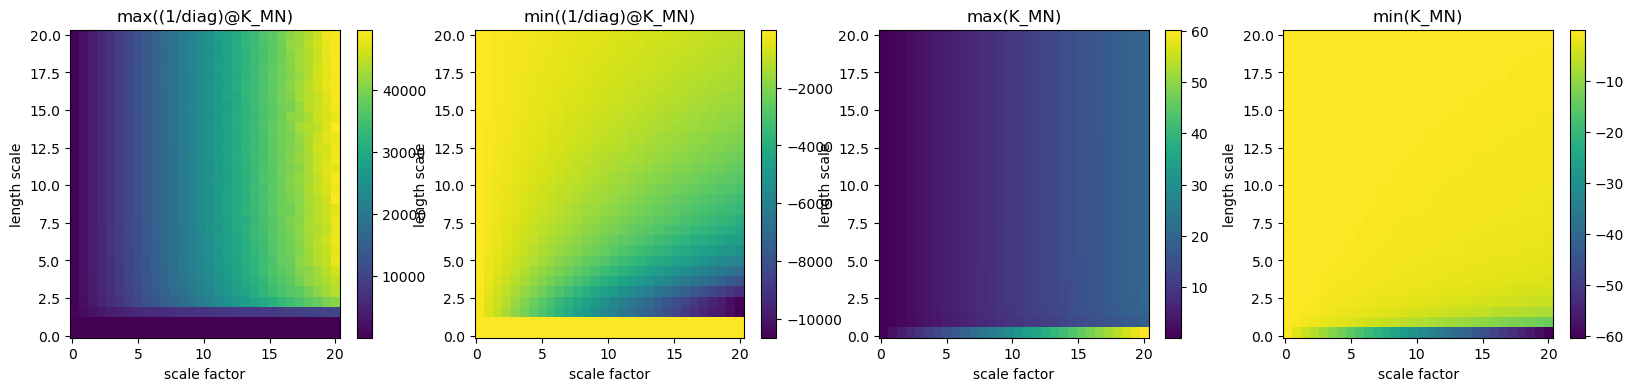

In [10]:
fig, ax = plt.subplots(1,len(res.T),figsize=(5*len(res.T),4))

for i,elem in enumerate(res.T):
    im = ax[i].pcolormesh(grid, grid, elem.T)
    plt.colorbar(im, ax=ax[i])
    ax[i].set_xlabel("scale factor")
    ax[i].set_ylabel("length scale")

ax[0].set_title("max((1/diag)@K_MN)")
ax[1].set_title("min((1/diag)@K_MN)")
ax[2].set_title("max(K_MN)")
ax[3].set_title("min(K_MN)")

### Multiplying matrices of same size instead of one large and one small matrix

In [11]:
def _mul_diag(diag, matrix):
    return diag*matrix
mul_diag = jax.vmap(_mul_diag, in_axes=(0,0))

diag = jnp.arange(1,11)
mat = jnp.ones((10,2))

print(diag.shape, mat.shape)

mul_diag(diag, mat)

(10,) (10, 2)


DeviceArray([[ 1.,  1.],
             [ 2.,  2.],
             [ 3.,  3.],
             [ 4.,  4.],
             [ 5.,  5.],
             [ 6.,  6.],
             [ 7.,  7.],
             [ 8.,  8.],
             [ 9.,  9.],
             [10., 10.]], dtype=float32)

### Evenly split diag between the left and the right matrix to multiply elements of the same size.

In [12]:
res = []

for param in params:
    res.append(sqrt_diag_contract(param))

res = jnp.array(res)
res = res.reshape(num_params, num_params, res.shape[-1])

Text(0.5, 1.0, 'min((1/sqrt(diag))@K_MN)')

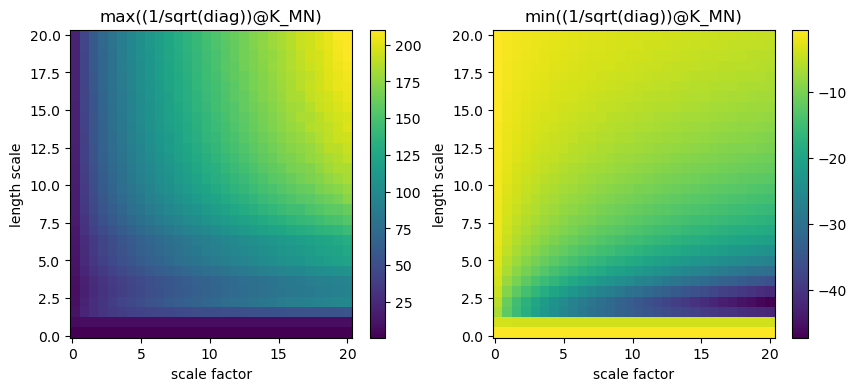

In [13]:
fig, ax = plt.subplots(1,len(res.T),figsize=(5*len(res.T),4))

for i,elem in enumerate(res.T):
    im = ax[i].pcolormesh(grid, grid, elem.T)
    plt.colorbar(im, ax=ax[i])
    ax[i].set_xlabel("scale factor")
    ax[i].set_ylabel("length scale")

ax[0].set_title("max((1/sqrt(diag))@K_MN)")
ax[1].set_title("min((1/sqrt(diag))@K_MN)")

### Is this enough to make it posdef? No some eigenvals are still complex and its not symmetric everywhere

In [14]:
res = []

for param in params:
    res.append(rel_err(param))

res = jnp.array(res)
res = res.reshape(num_params, num_params, res.shape[-1])

Text(0.5, 1.0, 'Absolute Error')

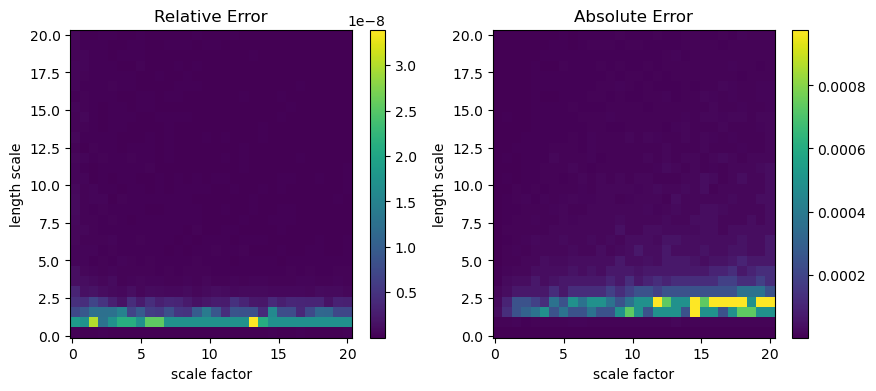

In [15]:
fig, ax = plt.subplots(1,len(res.T),figsize=(5*len(res.T),4))

for i,elem in enumerate(res.T):
    im = ax[i].pcolormesh(grid, grid, elem.T)
    plt.colorbar(im, ax=ax[i])
    ax[i].set_xlabel("scale factor")
    ax[i].set_ylabel("length scale")

ax[0].set_title("Relative Error")
ax[1].set_title("Absolute Error")

### Size comparison `K_ref` and `mat.T@mat`

In [16]:
res = []

for param in params:
    res.append(k_ref_mat_size(param))

res = jnp.array(res)
res = res.reshape(num_params, num_params, res.shape[-1])

Text(0.5, 1.0, 'min(mat)')

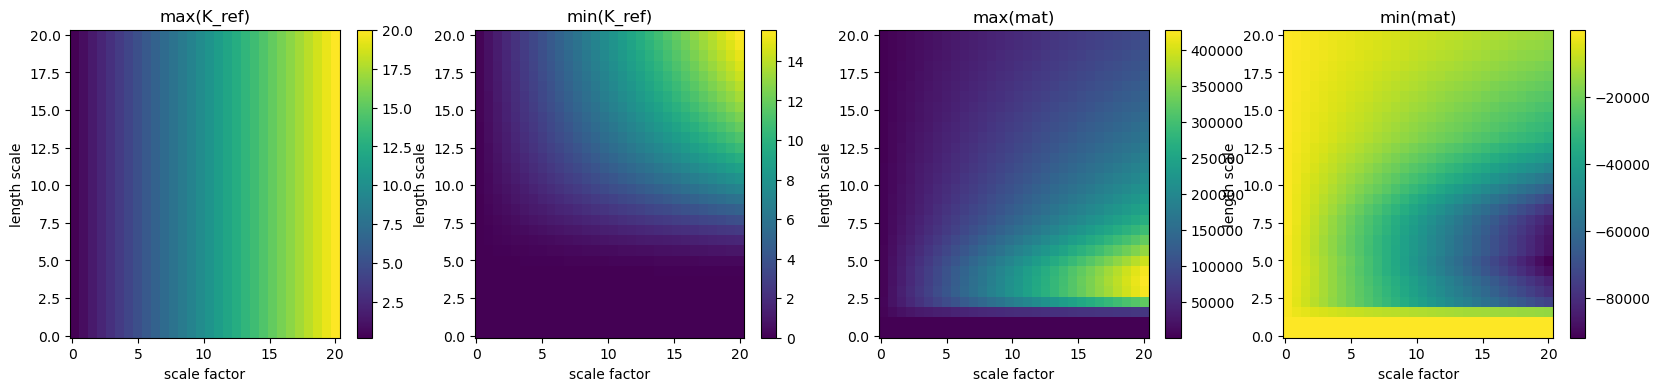

In [17]:
fig, ax = plt.subplots(1,len(res.T),figsize=(5*len(res.T),4))

for i,elem in enumerate(res.T):
    im = ax[i].pcolormesh(grid, grid, elem.T)
    plt.colorbar(im, ax=ax[i])
    ax[i].set_xlabel("scale factor")
    ax[i].set_ylabel("length scale")

ax[0].set_title("max(K_ref)")
ax[1].set_title("min(K_ref)")
ax[2].set_title("max(mat)")
ax[3].set_title("min(mat)")

In [18]:
def is_sym(x):
    container = jax.jit(k_inv)(X_split, X_ref, noise, kernel, x)

    mat = container.even_k_mn
    mat = mat.T@mat
    # mat = 0.5*(mat + mat.T)

    return jnp.allclose(mat, mat.T)

In [19]:
res = []

for param in params:
    res.append(is_sym(param))

res = jnp.array(res)
res = res.reshape(num_params, num_params)

Text(0.5, 1.0, 'max(K_ref)')

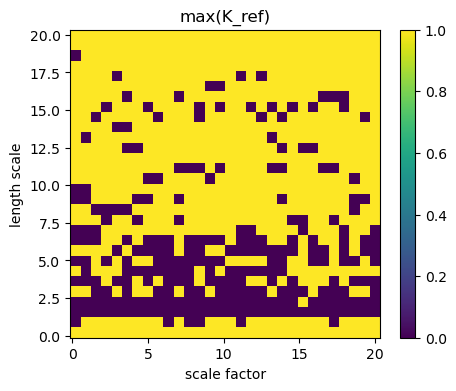

In [20]:
fig, ax = plt.subplots(1,1,figsize=(5,4))

im = ax.pcolormesh(grid, grid, res)
plt.colorbar(im, ax=ax)
ax.set_xlabel("scale factor")
ax.set_ylabel("length scale")

ax.set_title("max(K_ref)")

### Is it enough to symmetrize out the error to get K_inv to be posdef? `NO`

In [21]:
def posdef(x):
    container = jax.jit(k_inv)(X_split, X_ref, noise, kernel, x)
    
    # K_inv = 0.5*(container.k_inv + container.k_inv.T)
    K_inv = container.k_inv
    
    cho, _ = jsp.linalg.cho_factor(K_inv)
    # eigens = jnp.linalg.eigvalsh(K_inv)

    return jnp.any(jnp.isnan(cho))
    return jnp.min(eigens)

In [22]:
res = []

for param in params:
    res.append(posdef(param))

res = jnp.array(res)
res = res.reshape(num_params, num_params)

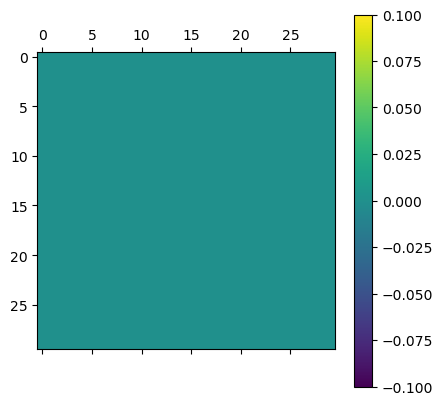

In [23]:
plt.matshow(res)
plt.colorbar()

In [27]:
# fig, ax = plt.subplots(1,len(res.T),figsize=(5*len(res.T),4))

# for i,elem in enumerate(res.T):
#     im = ax[i].pcolormesh(grid, grid, elem.T)
#     plt.colorbar(im, ax=ax[i])
#     ax[i].set_xlabel("scale factor")
#     ax[i].set_ylabel("length scale")

# ax[0].set_title("max((1/diag)@K_MN)")
# ax[1].set_title("min((1/diag)@K_MN)")

## TODO

In [24]:
errs = []

for param in params:
    # m, i = func(param)
    # min_eigen.append(m)
    # is_sym.append(i)
    errs.append(rel_err(param))

errs = jnp.array(errs)
errs = errs.reshape(num_params, num_params, errs.shape[-1])

Text(0.5, 1.0, 'max element in k_inv')

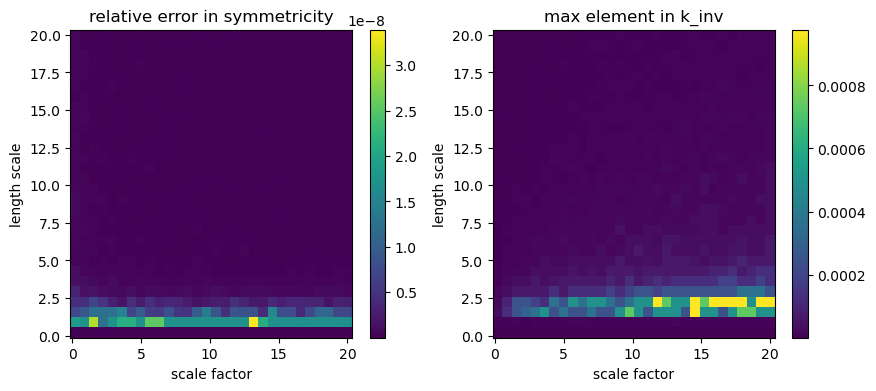

In [25]:
fig, ax = plt.subplots(1,2,figsize=(10,4))

for i in range(2):
    im = ax[i].pcolormesh(grid, grid, errs[:,:,i])
    plt.colorbar(im, ax=ax[i])
    ax[i].set_xlabel("scale factor")
    ax[i].set_ylabel("length scale")

ax[0].set_title("relative error in symmetricity")
ax[1].set_title("max element in k_inv")

In [26]:
out.shape

NameError: name 'out' is not defined

In [ ]:
print(out[:,:,-1].shape)

In [ ]:
print(jnp.all(out[:,:,-2:] > 0))